### Task E : Implementing Decision Function of SVM RBF Kernel

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)

In [3]:
# split test train and cross validation data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=42)
X_cv,X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=43)

print("XTrain shape",X_train.shape )
print("XTest shape",X_test.shape )
print("XCv shape",X_cv.shape )

# fit RBF svc to Xtrain data
svc_clf = SVC(gamma=0.001, C= 100)
svc_clf.fit(X_train,y_train)

dual_coefs = svc_clf.dual_coef_
intercept = svc_clf.intercept_
support_vectors = svc_clf.support_vectors_
gamma = 0.001

XTrain shape (3000, 5)
XTest shape (1000, 5)
XCv shape (1000, 5)


In [4]:
def rbf(xi,xq, gamma):
    """
    Function to get RBF kernel value

    """
    # 𝑒𝑥𝑝(−𝛾||𝑥𝑖−𝑥𝑞||2)
    
    X_norm = np.sum((xi-xq) **2,axis= -1)
    return np.exp(-gamma * X_norm)


In [5]:
def getKernel(supportVectors, X, gamma):
    """
    Function to get Kernel Matrix
    Kernel used : RBF

    """
    Kernels = np.zeros((X.shape[0], supportVectors.shape[0]))
    for id, point in enumerate(X):
        for idx, vector in enumerate(supportVectors):
            rbf_ = rbf(point, vector, gamma)
            Kernels[id][idx] = rbf_

    return Kernels

In [6]:
def decision_function_custom(X, intercept, dual_coeff, support_vector, gamma ) :
    """
    return decison function for svm rbf kernel.

    parameters:
      X : Data
      intercept :  intercept value of classfier
      dual_coeff : dual values( alpha * y)
      support_vector : array of  support vector

    returns:
      decision function : sum_all_supoort_vectors(yi*alpha_i * Kernel(xi,xq) ) + intecept
     """
    Kernels = getKernel(support_vector, X,  gamma)
    decision_custom = np.sum(dual_coeff * Kernels, axis = -1) + intercept
    return decision_custom


In [7]:
f_cv = decision_function_custom(X_cv,intercept, dual_coefs, support_vectors, 0.001 )

f_cv

array([-4.54631892e+00, -3.18769119e+00,  1.62139697e+00,  8.61360038e-02,
        1.75246241e+00, -9.76830808e-01, -3.20246796e+00, -2.62082863e+00,
       -2.42937891e+00,  1.57993649e+00, -2.06329703e+00,  9.02139954e-01,
       -2.49633212e+00, -3.12153041e+00,  2.98793441e-01, -9.79851167e-02,
       -2.10058057e+00, -3.05987657e+00,  6.09426723e-01, -2.28247363e+00,
        1.83705137e+00, -1.49963660e+00,  1.64502533e+00,  1.74774640e+00,
        8.64699998e-01, -2.44402367e+00, -2.77765859e+00,  2.81547371e+00,
        5.69770433e-01, -2.75397962e+00, -3.38300646e+00, -2.98418538e+00,
       -3.96622930e+00, -3.17731359e+00, -2.46000821e+00, -2.51646933e+00,
       -3.78091581e+00, -2.92728890e+00,  1.55489810e+00,  1.38727315e+00,
        1.44977701e+00,  9.80246803e-01, -3.50913018e+00,  3.68527290e+00,
        9.93865029e-01,  1.64063405e+00,  1.44693130e+00, -3.46194602e+00,
       -2.92257250e+00, -3.04151815e-01, -2.88716371e+00, -2.01001616e+00,
       -2.96415173e+00, -

In [8]:
# difference between custom decision value and sklearn decision and check for indices where difference is greater than 10 ^ -6 ,
# we can see we get array of length zero
np.where(f_cv - svc_clf.decision_function(X_cv) > 10e-6)

(array([], dtype=int64),)

### Task F : Implementing Platt Scaling to find P(Y==1|X)

In [9]:
def sigmoid(w,x,b):
    return 1/(1+np.exp(-(np.dot(x,w.T)+b))) #return 1/1+e(-x)

In [10]:
def logloss(w,x,y,b,reg=0):
    val=sigmoid(w,x,b)
    return -np.mean(y*np.log10(val)+(1-y)*np.log10(1-val))+reg  # cost function of logistic regression

In [11]:
count_one=list(y_train).count(1)
count_zero=list(y_train).count(0)      # calculating y+ and y_
y_plus=(count_one+1)/(count_one+2)
y_minus=1/(count_zero+2)

In [12]:
def update(y_cv,y_plus,y_minus):
    u_cv=[]
    for point in y_cv:    # update function convert y_cv into y+,y_
        if point==1:
                u_cv.append(y_plus)
        else:
              u_cv.append(y_minus)
    return(np.array(u_cv))

In [13]:
y_cv_updated=update(y_cv,y_plus,y_minus)

In [14]:
w = np.zeros_like(f_cv[0])# initial weight vector
b = 0      # initial intercept value
eta0  = 0.0001  # learning rate
alpha = 0.0001 # lambda value
N = len(f_cv)
print(len(y_cv_updated))
print(N)

1000
1000


In [15]:
ini=logloss(w,f_cv,y_cv_updated,b)
print("Initial log loss =",ini)

Initial log loss = 0.3010299956639812


### SGD alorithm for calculating optimal w and b


In [16]:
def sgd_algo(f_cv,y_cv_updated,eta0,alpha,w,b,epoch):
    t=0.001 # tolerence
    test_loss=[]
    epoc=[]
    for i in  range(0,epoch): 
        epoc.append(i)
        for j in range(0,N):
            reg=alpha/2*np.dot(w.T,w) #regulrization term
            w = ((1-eta0*(alpha/N))*w)+((eta0*f_cv[j])*(y_cv_updated[j]-sigmoid(w,f_cv[j],b))) # updating weight vector
            b = b+(eta0*(y_cv_updated[j]-sigmoid(w,f_cv[j],b)))       # updatind intercept    
        test=logloss(w,f_cv,y_cv_updated,b,reg)
        test_loss.append(test)
        if i<=t :
            continue                                                                  
            if abs(test_loss[i]-test_loss[i-1])>t: # block to check convergence 
                continue
            else:
                break 
    return w,b,epoc,test_loss

In [17]:
epoch=45
we,be,epo,loss=sgd_algo(f_cv,y_cv_updated,eta0, alpha,w,b,epoch)
print("optimal weight = ",we)
print("optimal intercept = ",be)

optimal weight =  1.1449699301415204
optimal intercept =  -0.11335493592139145


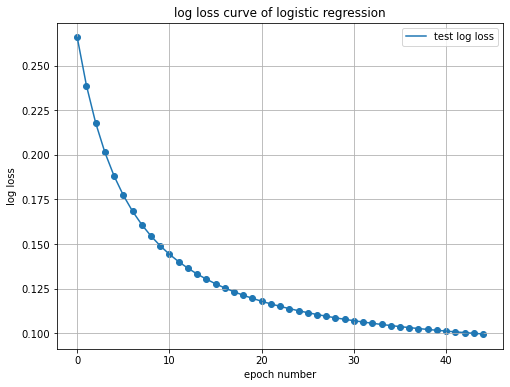

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(epo,loss, label='test log loss')
plt.scatter(epo,loss)
plt.title('log loss curve of logistic regression')
plt.xlabel('epoch number')
plt.ylabel("log loss")
plt.legend()

In [19]:
f_test=decision_function_custom(X_test,intercept, dual_coefs, support_vectors, gamma)

def probability(f_test,w,b):
    p=1/(1+np.exp(-w*f_test+b)) # to calculate probilty P(Y=1|X)
    return p

prob = probability(f_test,we,be)
print("The top 10 probabilities are:",prob[:10])

The top 10 probabilities are: [0.03349361 0.8924317  0.29748392 0.05499249 0.42894947 0.04339435
 0.03226516 0.14468386 0.8812426  0.08964745]
